In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
from phantasy import caget

In [5]:
import objFuncs
from objFuncs import residuals
from objFuncs.util import plot_obj_history, plot_multi_obj_history

objFuncs version: 1.0.2. updated on 2023-12-19


# check machineIO, source and beam 

In [6]:
objFuncs._global_machineIO._test = False
objFuncs._ensure_set_timeout = 60
objFuncs._global_machineIO._fetch_data_time_span = 2.0
objFuncs._global_machineIO._ensure_set_timewait_after_ramp : 0.25
objFuncs._global_machineIO.view()

   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 2.0
   _return_obj_var : False
   _check_chopper_blocking : True
   _n_popup_ramping_not_OK : 0
   _verbose : False


In [7]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 238U35 A/Q= 6.8


# preprare objective (for residual construction)

In [8]:
now0 = datetime.datetime.now()
now0str = now0.strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+'][LSQ][FS1][before1stDipole]QuadCentering'
fname

'20231219_0419[238U35][LSQ][FS1][before1stDipole]QuadCentering'

In [9]:
decision_CSETs=[
    'FS1_CSS:PSC2_D2351:I_CSET',
    'FS1_CSS:PSC1_D2351:I_CSET',
    'FS1_CSS:PSC2_D2367:I_CSET',
    'FS1_CSS:PSC1_D2367:I_CSET'
]
decision_min = [-1.5*AQ]*len(decision_CSETs)
decision_max = [ 1.5*AQ]*len(decision_CSETs)

print(f'decision_min: {decision_min}')
print(f'decision_max: {decision_max}')

decision_min: [-10.2, -10.2, -10.2, -10.2]
decision_max: [10.2, 10.2, 10.2, 10.2]


In [10]:
objective_goal = { 
    'FS1_BBS:BPM_D2421:XPOS_RD' : 0.0,
    'FS1_BBS:BPM_D2421:YPOS_RD' : 0.0,
    'FS1_BBS:BPM_D2466:XPOS_RD' : 0.0,
    'FS1_BBS:BPM_D2466:YPOS_RD' : 0.0,
    'FS1_BMS:BPM_D2502:XPOS_RD' : 0.0,
    'FS1_BMS:BPM_D2502:YPOS_RD' : 0.0,
}
objective_norm = {pv:1.0 for pv in objective_goal.keys()}
objective_weight = {pv:1.0 for pv in objective_goal.keys()}
objective_RDs = list(objective_goal.keys())

In [11]:
conditional_SETs = {
    'FS1_CSS:PSQ_D2372:I_CSET':[],
    'FS1_CSS:PSQ_D2377:I_CSET':[],
}

In [12]:
for i,PV in enumerate(conditional_SETs.keys()):
    x0 = caget(PV)
    conditional_SETs[PV] = [x0]*(2*len(conditional_SETs)+1)
    conditional_SETs[PV][2*i+1] = x0 - 2*AQ
    conditional_SETs[PV][2*i+2] = x0 + 2*AQ

In [13]:
n_condition = len(list(conditional_SETs.values())[0])
conditional_SETs

{'FS1_CSS:PSQ_D2372:I_CSET': [78.644,
  65.04400000000001,
  92.244,
  78.644,
  78.644],
 'FS1_CSS:PSQ_D2377:I_CSET': [53.142, 53.142, 53.142, 39.542, 66.742]}

In [14]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min = decision_min,
    decision_max =  decision_max,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 1.0,
    )

[condition_controller] ======== class info ========
init_time: 2023-12-19 04:19:15.315124
class_hierarchy: [
    objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7fd71df90450>
decision_CSETs: [
    FS1_CSS:PSQ_D2372:I_CSET, FS1_CSS:PSQ_D2377:I_CSET]
decision_min: [65.044 39.542]
decision_max: [92.244 66.742]
decision_bounds: [[65.044 92.244]
 [39.542 66.742]]
decision_RDs: [
    FS1_CSS:PSQ_D2372:I_RD, FS1_CSS:PSQ_D2377:I_RD]
decision_tols: [6. 6.]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: condition_controler
logging_fname: None
x0: [78.644 53.142]

[condition 0] ======== class info ========
init_time: 2023-12-19 04:19:18.345714
class_hierarchy: [
    residualObj, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7fd71c220d50>
decision_CSETs: [
    FS1_CSS:PSC2_D2351:I_CSET, FS1_CSS:PSC1_D2351:I_CSET, FS1_CSS:PSC2_D2367:I_CSET
    FS1_CSS:PSC1_D2367:I_CSET]
decision_min

In [15]:
plot_decision = plot_obj_history(
    res.history['decision_CSETs'],
    title='decision_CSETs',
)
plot_conditions_RDs = plot_multi_obj_history(
    histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
    history_labels = ['C'+str(i) for i in range(n_condition)],
    title='multi-condition_obj_RDs',
)
plot_objectives_var = plot_obj_history(
    res.history['objectives_var'],
    title='objectives_var',
)
plot_cond_control = plot_obj_history(
    res.history['condition controller']['decision_CSETs'],
    title='condition controller',
)

callbacks = [plot_decision,plot_conditions_RDs,plot_objectives_var,plot_cond_control]
# callbacks = []

In [35]:
res.history['decision_CSETs']['values'][2]

array([ 2.51120000e+00, -1.81200000e+00,  1.77635684e-15,  1.27500000e+00])

ramping_not_OK. trying again...


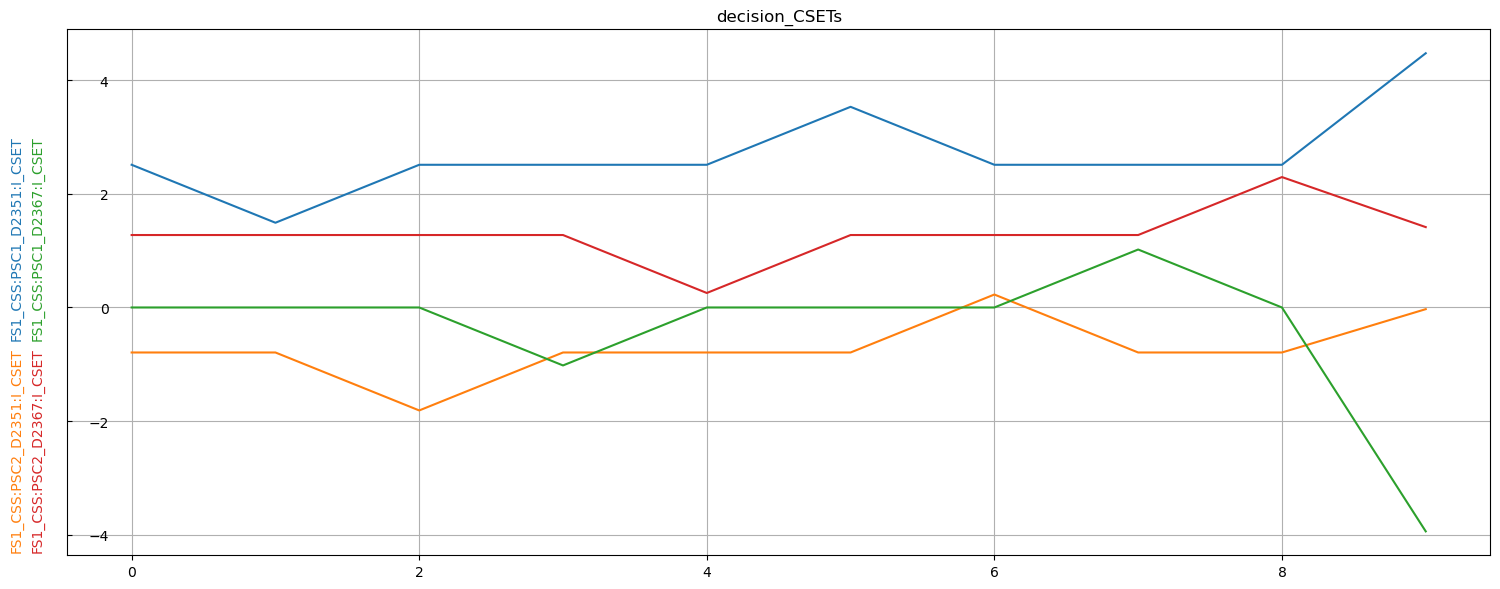

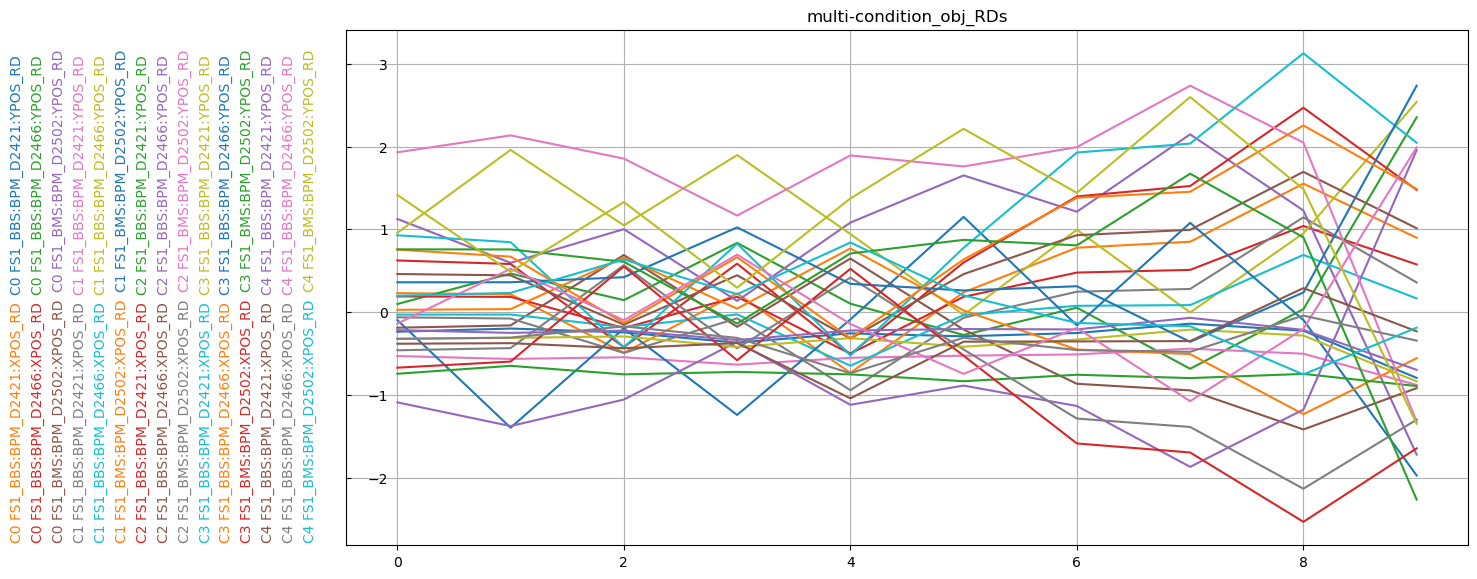

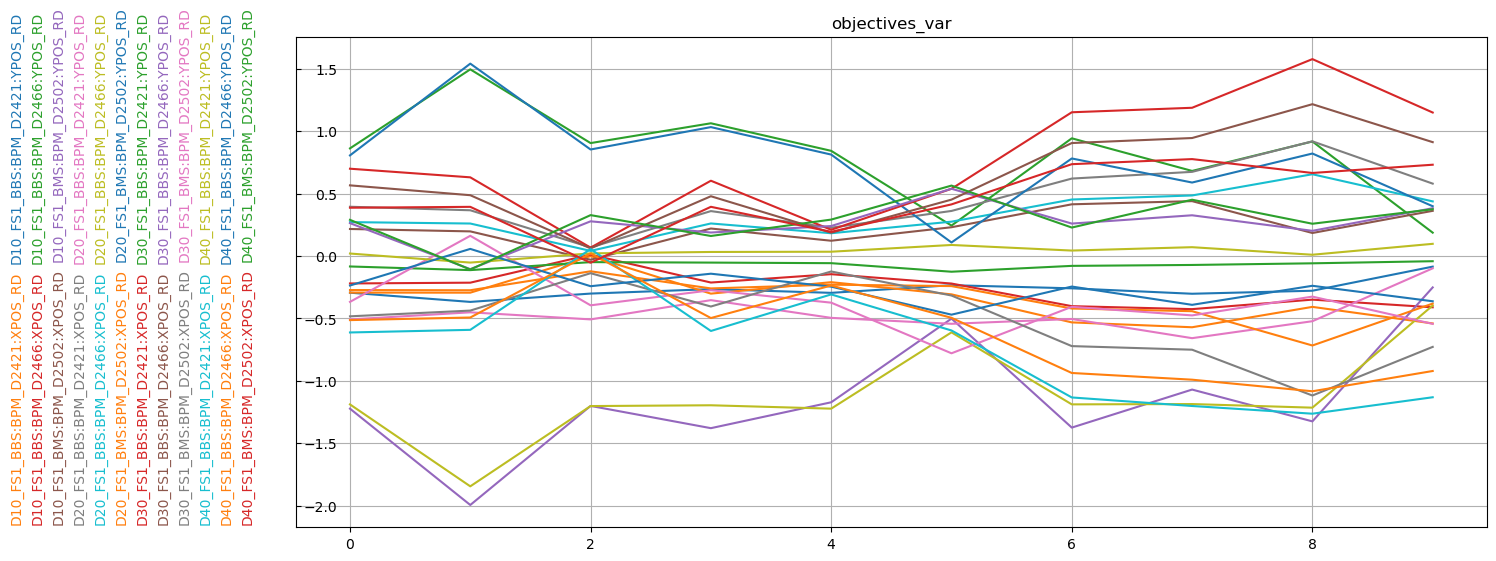

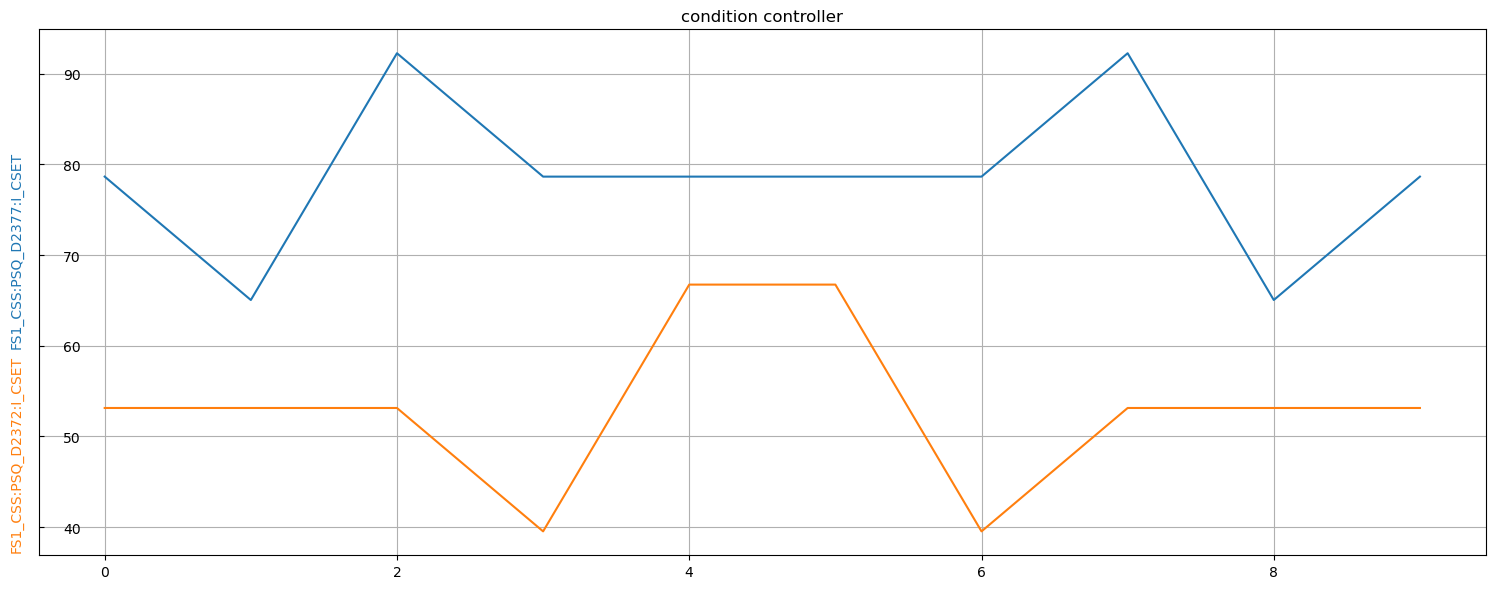

In [16]:
result = res.lsq_linear(jac_use3points=True,callbacks=callbacks)
res.condition_controller._set_decision(res.condition_controller.x0)
for f in callbacks:
    f.close()

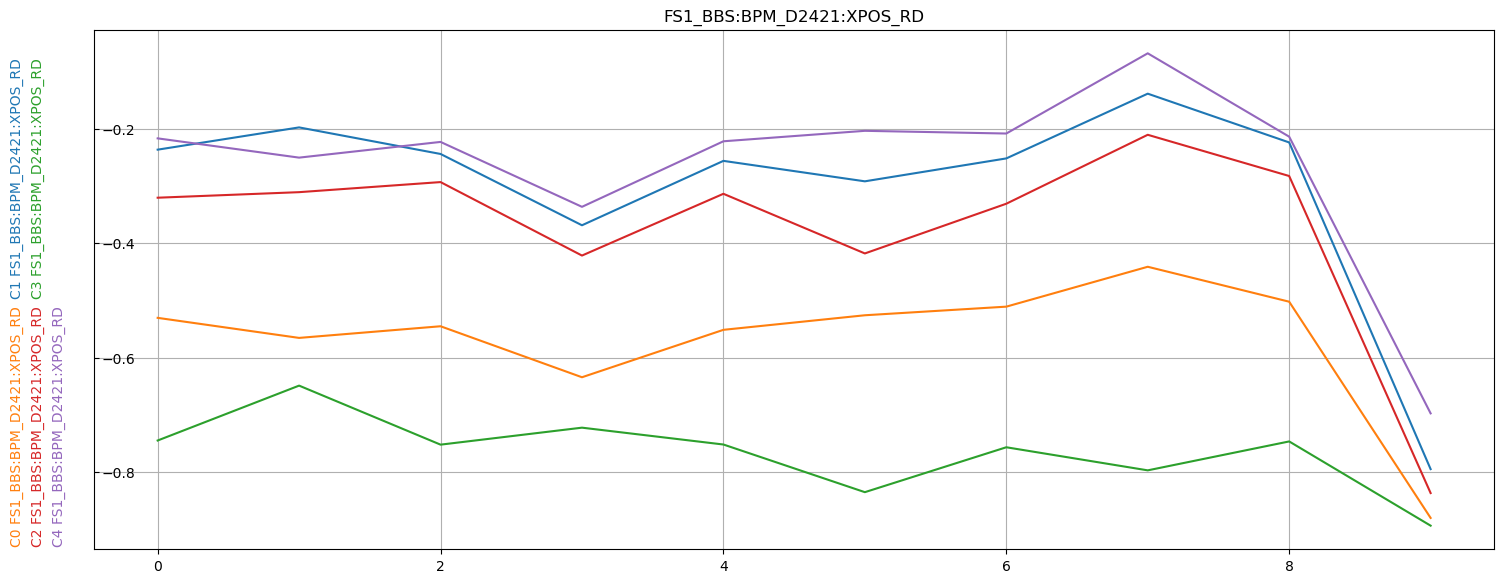

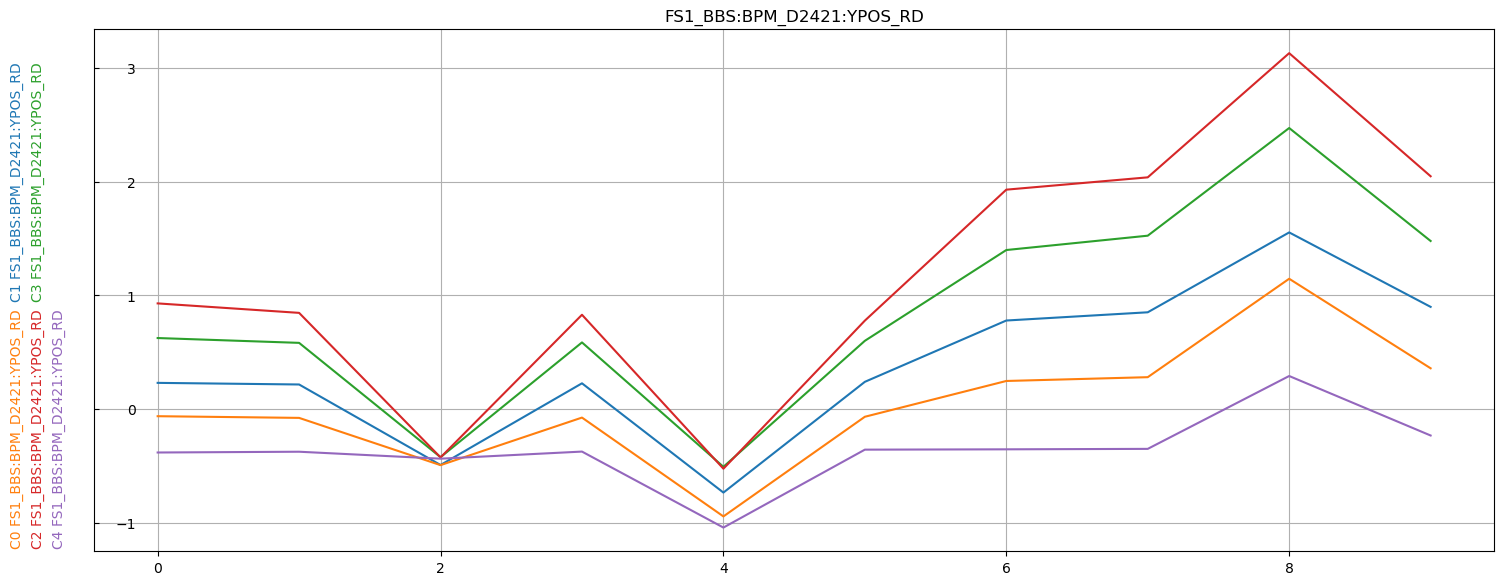

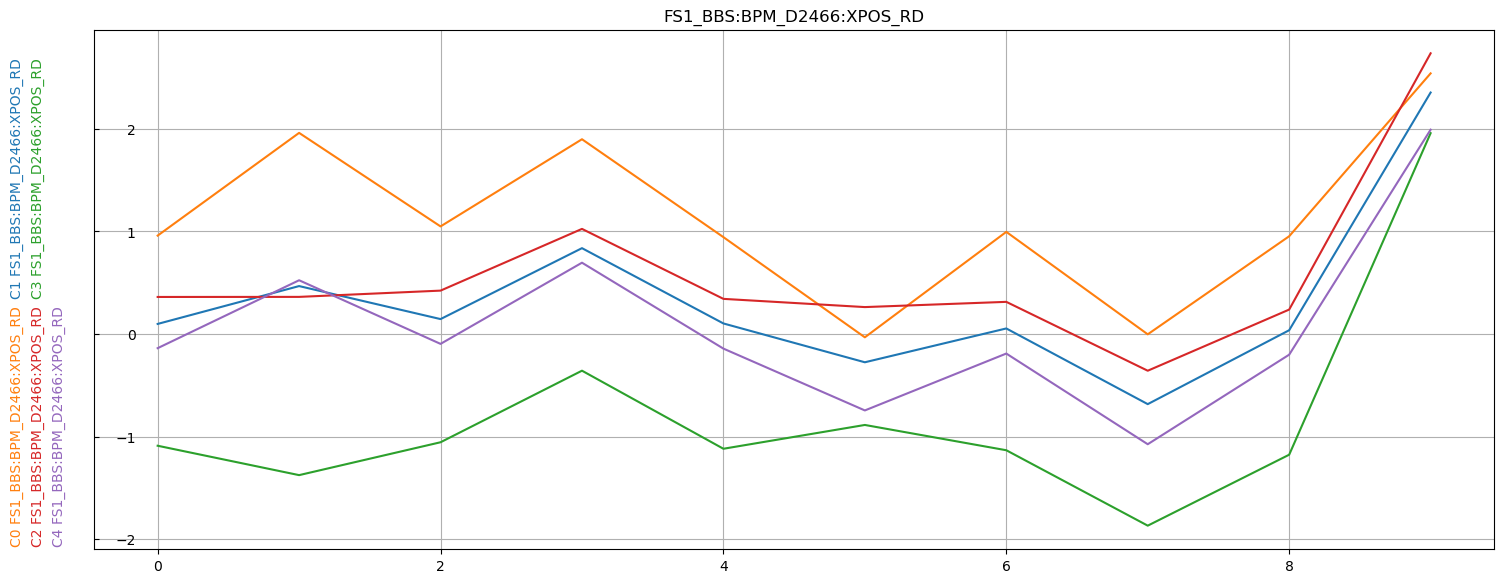

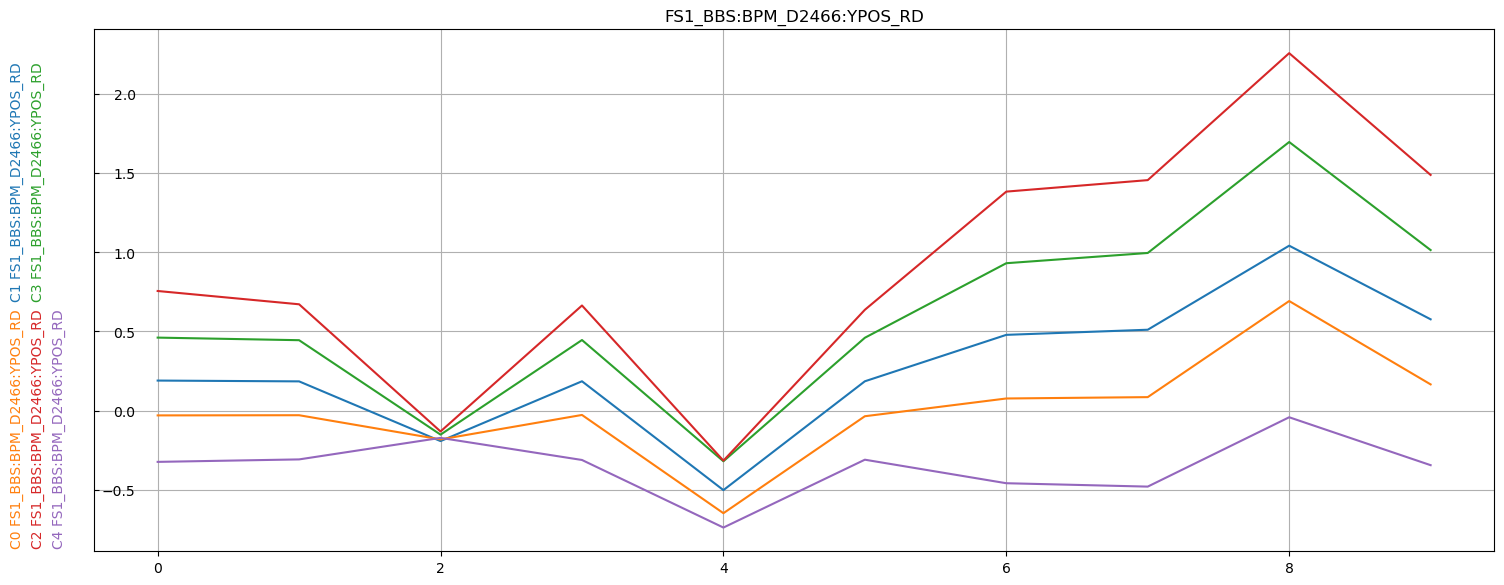

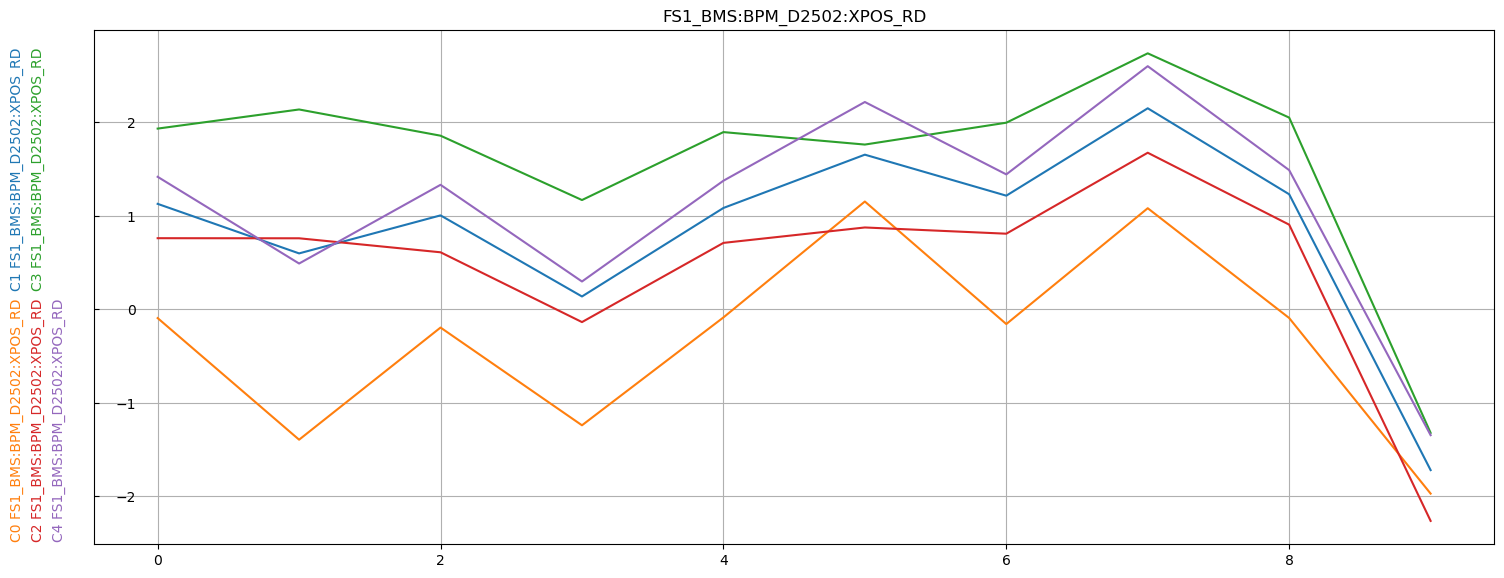

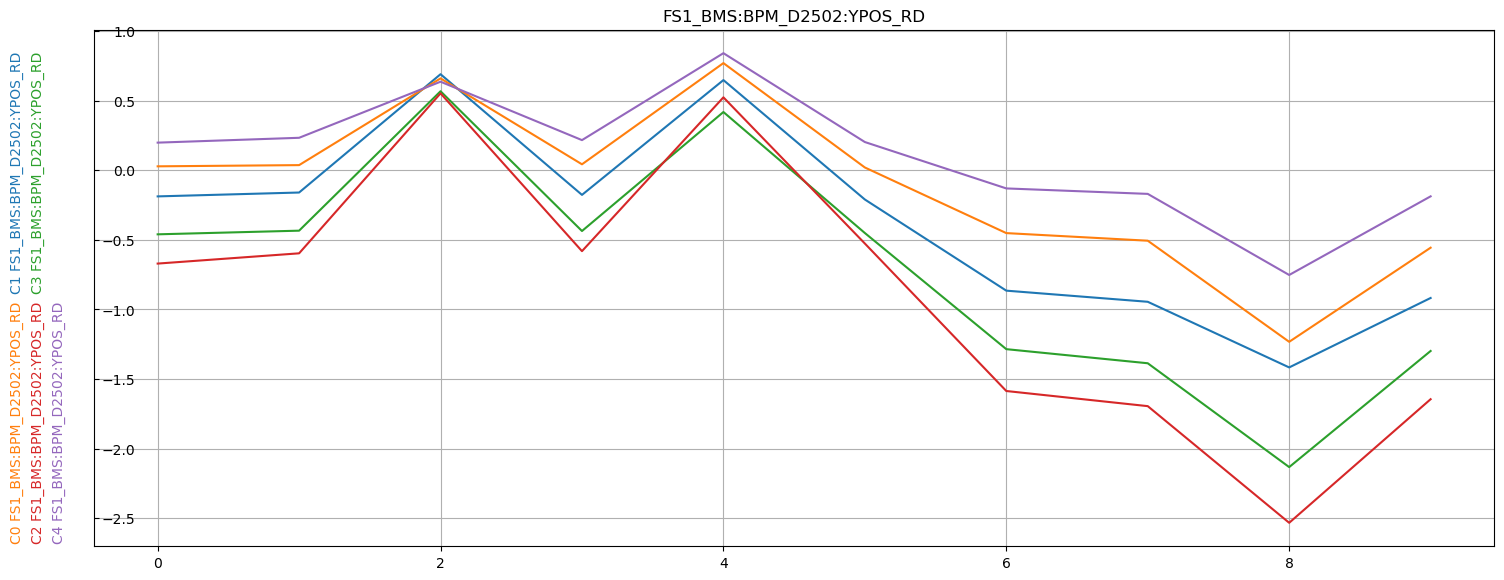

In [17]:
for key in objective_goal.keys():
    plot_conditions_RDs = plot_multi_obj_history(
        histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
        history_labels = ['C'+str(i) for i in range(n_condition)],
        title= key,
        keys = [[key]],
    )
    plot_conditions_RDs()
    plot_conditions_RDs.close()

In [18]:
for name, val in zip(res.history['jacobian_var']['names'], res.history['jacobian_var']['values'][0]):
    print( name, val )

d (D10 FS1_BBS:BPM_D2421:XPOS_RD)/d FS1_CSS:PSC2_D2351:I_CSET 0.06550661558846951
d (D10 FS1_BBS:BPM_D2421:XPOS_RD)/d FS1_CSS:PSC1_D2351:I_CSET 0.020588368630374273
d (D10 FS1_BBS:BPM_D2421:XPOS_RD)/d FS1_CSS:PSC2_D2367:I_CSET -0.018069959711735677
d (D10 FS1_BBS:BPM_D2421:XPOS_RD)/d FS1_CSS:PSC1_D2367:I_CSET 0.00829291650051461
d (D10 FS1_BBS:BPM_D2421:YPOS_RD)/d FS1_CSS:PSC2_D2351:I_CSET -0.00659798091605733
d (D10 FS1_BBS:BPM_D2421:YPOS_RD)/d FS1_CSS:PSC1_D2351:I_CSET -0.25990388957298893
d (D10 FS1_BBS:BPM_D2421:YPOS_RD)/d FS1_CSS:PSC2_D2367:I_CSET -0.131887187806428
d (D10 FS1_BBS:BPM_D2421:YPOS_RD)/d FS1_CSS:PSC1_D2367:I_CSET -0.09686544804178587
d (D10 FS1_BBS:BPM_D2466:XPOS_RD)/d FS1_CSS:PSC2_D2351:I_CSET -0.6128197970994758
d (D10 FS1_BBS:BPM_D2466:XPOS_RD)/d FS1_CSS:PSC1_D2351:I_CSET 0.018736652876072946
d (D10 FS1_BBS:BPM_D2466:XPOS_RD)/d FS1_CSS:PSC2_D2367:I_CSET -0.18687752120832274
d (D10 FS1_BBS:BPM_D2466:XPOS_RD)/d FS1_CSS:PSC1_D2367:I_CSET 0.03669717795652966
d (D10 FS

In [19]:
res.write_log(fname=os.path.join('./log',fname))

only .pkl file extension is accepted. saving to: ./log/20231219_0419[238U35][LSQ][FS1][before1stDipole]QuadCentering.pkl


In [20]:
res(res.x0)

array([-0.25582513, -0.31405939,  0.72012084, -0.23797774, -1.05493145,
        0.20342947, -0.45273846,  0.39046859, -1.20333032,  0.27912565,
        0.80409922, -0.31952384, -0.04840488,  0.61700279,  0.21958971,
        0.48408361, -0.32915945, -0.40658953,  0.07188693, -0.60148536,
       -0.32126884, -0.49510547,  0.34916043,  0.3637581 ])

In [21]:
res.condition_controller._set_decision(res.condition_controller.x0)

In [27]:
np.sum(res.history['objectives_var']['values'][0]**2)

7.297808862174055

In [28]:
np.sum(res.history['objectives_var']['values'][-1]**2)

6.434356454033972

In [29]:
res.x0

array([ 2.51120000e+00, -7.92000000e-01,  1.77635684e-15,  1.27500000e+00])

In [45]:
res.history['decision_CSETs']['values'][-3]

array([ 4.47404665, -0.02948293, -3.94003846,  1.41430139])

In [46]:
xnew = [caget(PV) for PV in decision_CSETs]

In [47]:
xnew

[4.474, -1.8, -3.94, 1.275]

In [48]:
res(np.array(xnew))

array([-0.18832782,  0.0322147 ,  0.54847388,  0.01111974, -0.66652288,
       -0.10071819, -0.1367397 ,  0.01558007, -0.67204339, -0.00544605,
        0.81884504, -0.09636926, -0.09247049, -0.12764975,  0.2151594 ,
       -0.1233813 , -0.34341763,  0.07051984,  0.02782347,  0.11957985,
       -0.37619187,  0.03804087,  0.44146834, -0.15191789])

In [49]:
res.condition_controller._set_decision(res.condition_controller.x0)

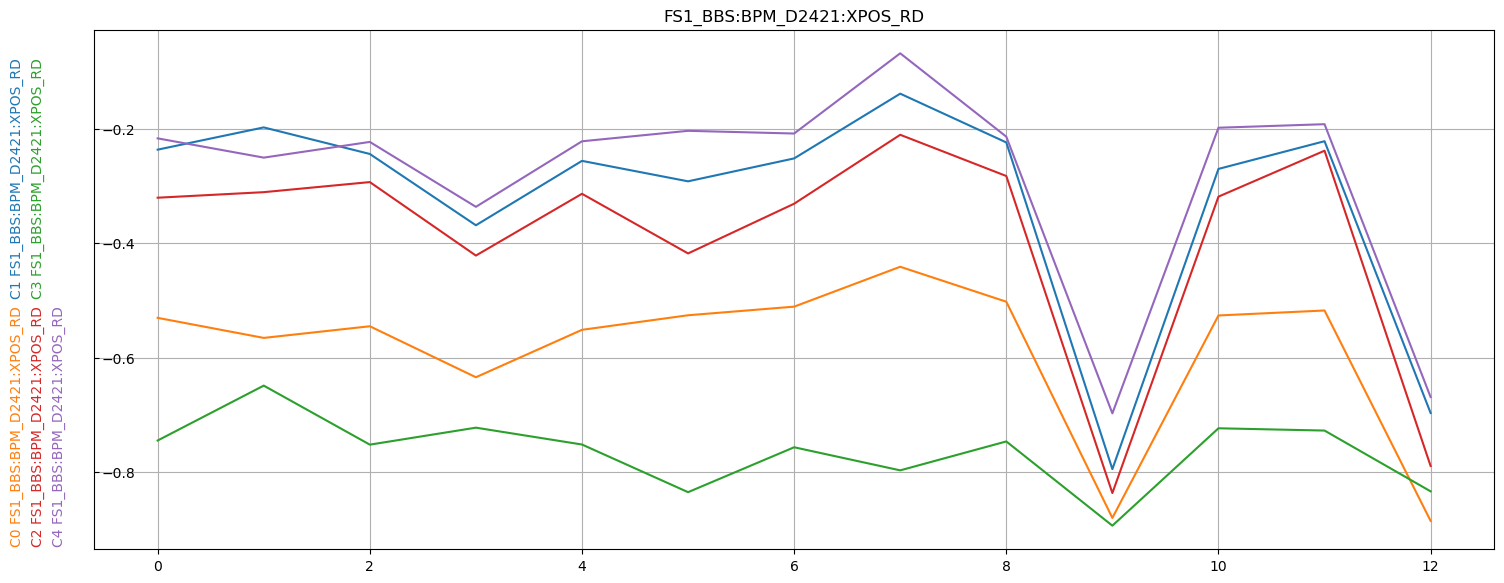

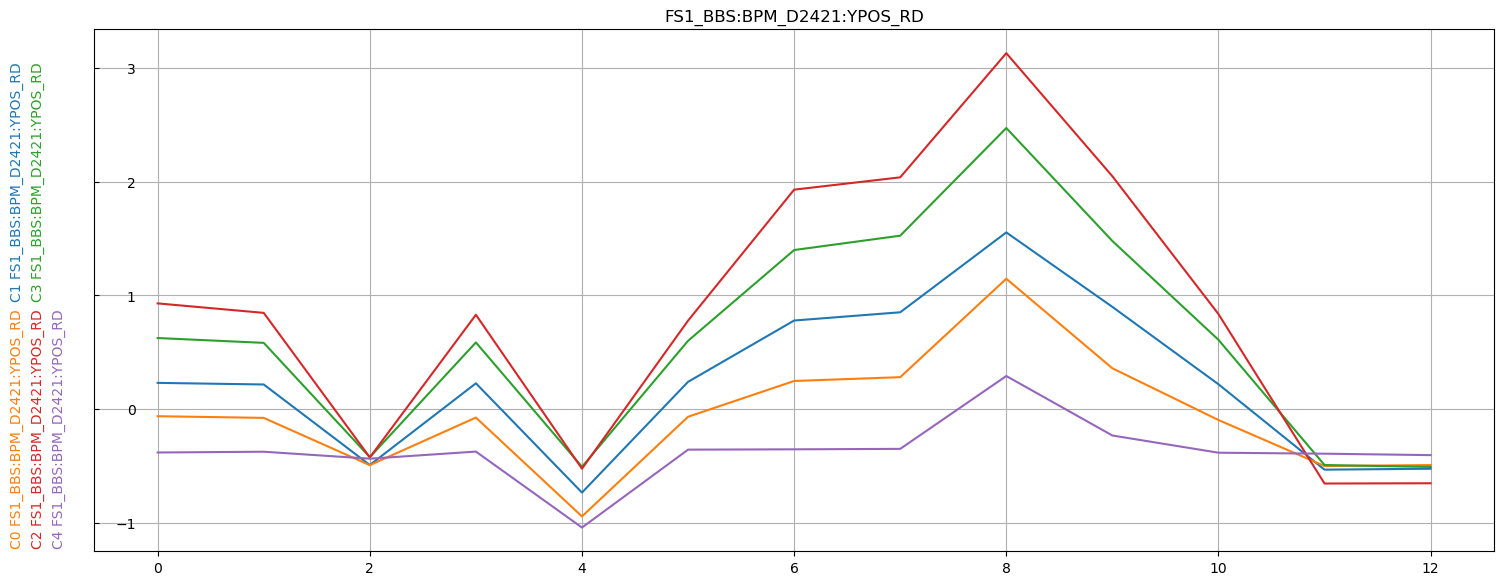

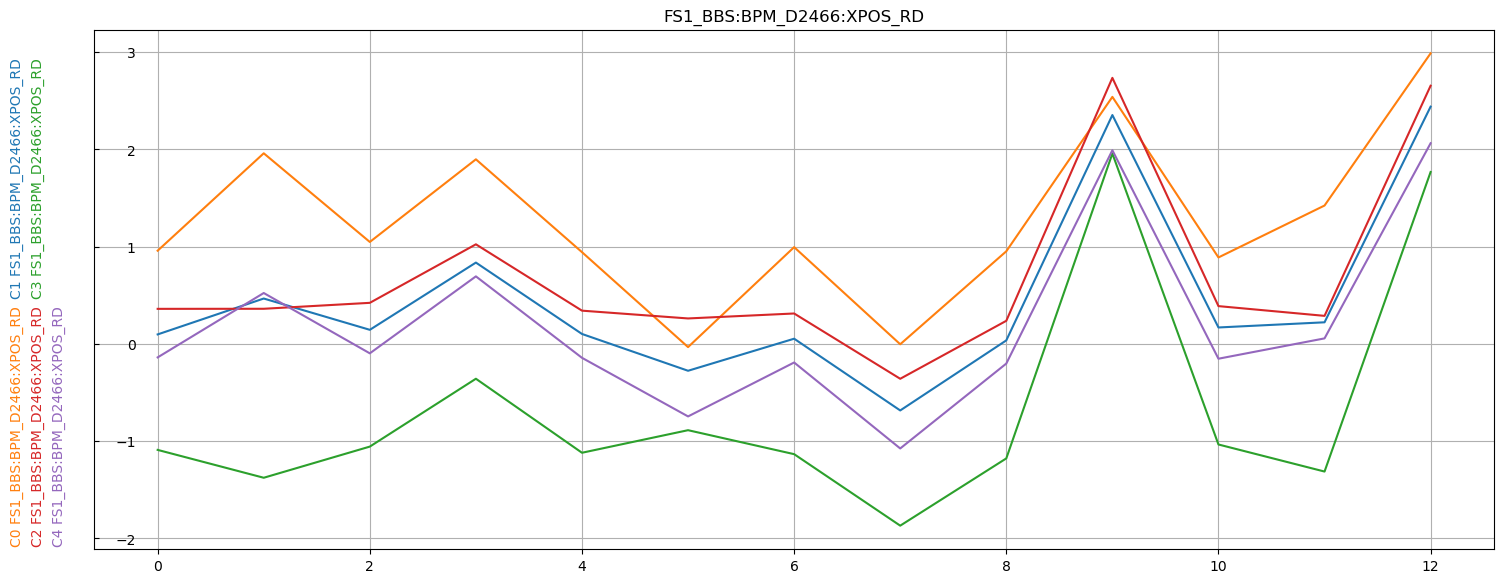

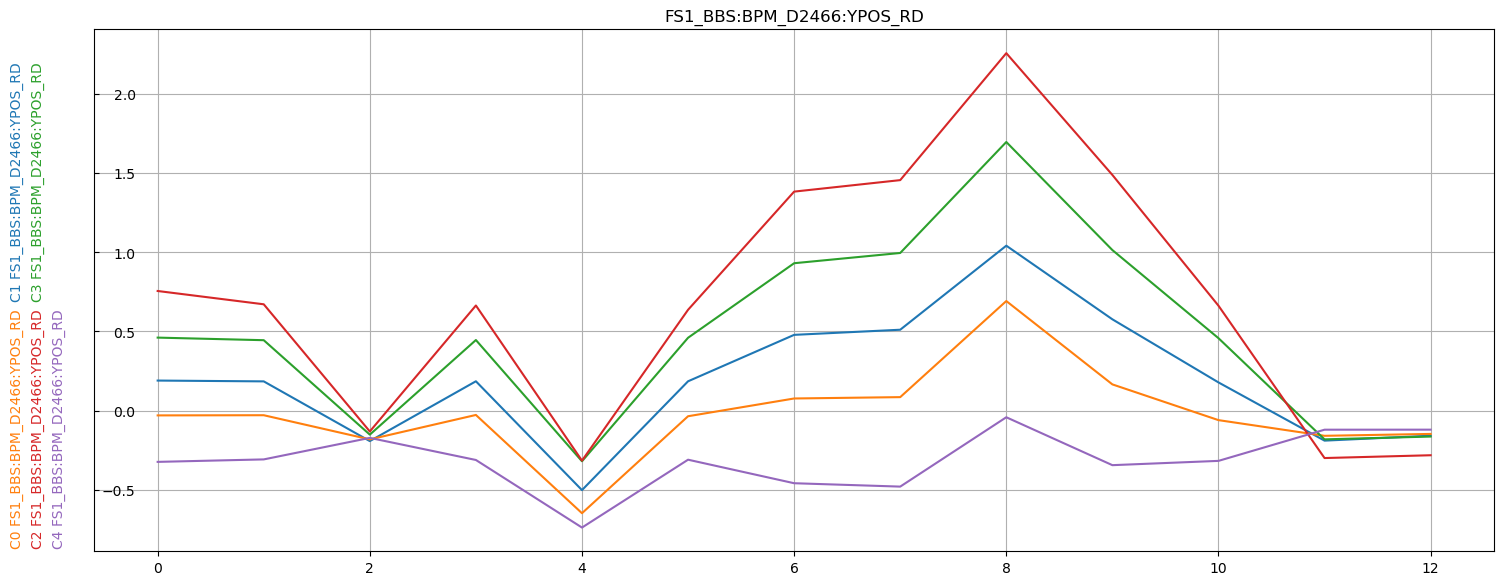

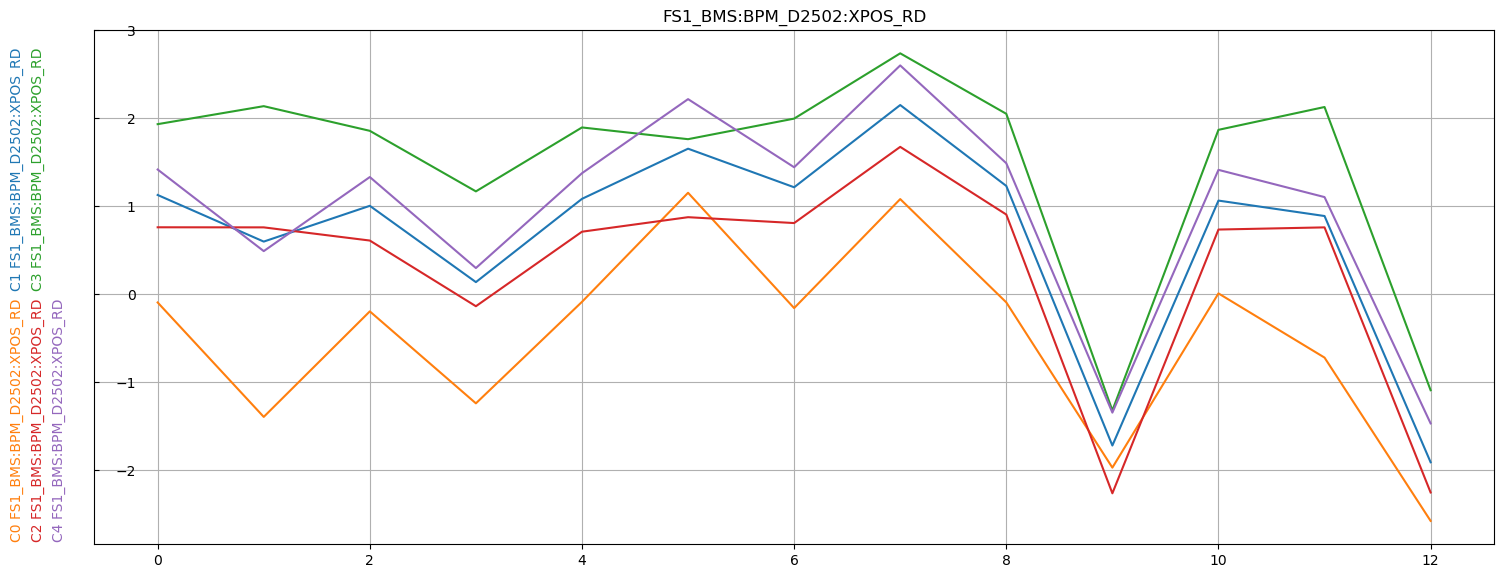

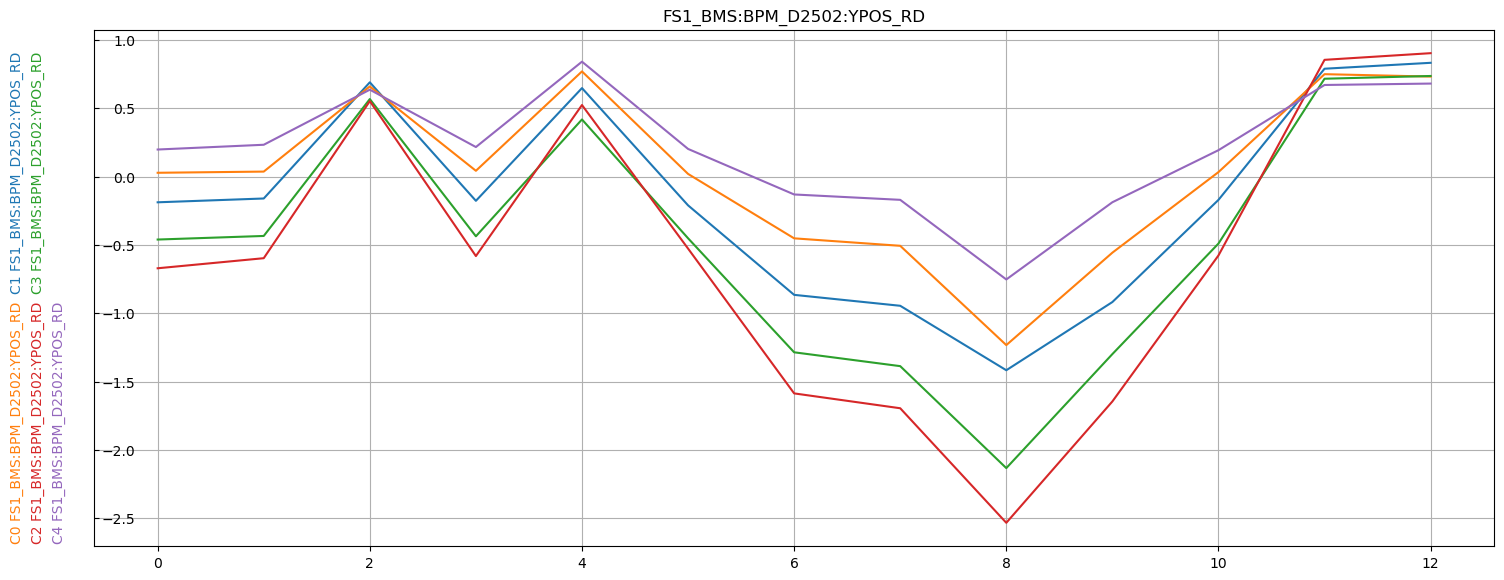

In [50]:
for key in objective_goal.keys():
    plot_conditions_RDs = plot_multi_obj_history(
        histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
        history_labels = ['C'+str(i) for i in range(n_condition)],
        title= key,
        keys = [[key]],
    )
    plot_conditions_RDs()
    plot_conditions_RDs.close()

In [51]:
np.sum(res.history['objectives_var']['values'][0]**2)

7.297808862174055

In [52]:
np.sum(res.history['objectives_var']['values'][-1]**2)

2.5275407345521415

CA.Client.Exception...............................................
    Context: "fs2-psc11-crt-n0108.ftc:5064"
    Source File: ../cac.cpp line 1237
    Current Time: Tue Dec 19 2023 05:28:05.276351180
..................................................................
